In [9]:
import os
import sys
import wandb
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from sklearn.model_selection import train_test_split
# Use these commands in the same cell to autoreload local library source code
# https://stackoverflow.com/questions/45807760/change-source-code-and-update-jupyter-notebook-but-retain-variables
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
torch.cuda.is_available()

True

In [26]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: dt-young112 (sccn). Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="hbn-ssl", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    #   name=f"experiment_{run}", 
      # Track hyperparameters and run metadata
      config={
        "n_subjects": 500,
        "window": 5,
        'mask_prob':0.3,
        'num_epochs': 10,
        'batch_size': 30,
        'epochs': 10
      })
config = wandb.config

In [4]:
def get_subjects(basedir):
    files = np.array([i for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    subjects = np.array([i.split('_')[0] for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    return subjects, files

subjects, files = get_subjects("/mnt/nemar/child-mind-rest")
subj_train, subj_test, files_train, files_test = train_test_split(subjects, files, test_size=0.1, random_state=1)
subj_train, subj_val, files_train, files_val = train_test_split(subj_train, files_train, test_size=0.22, random_state=1) # 0.22 x 0.9 = 0.2

In [4]:
dataset = HBNRestBIDSDataset(
        data_dir = "/mnt/nemar/openneuro/ds004186",
        x_params = {
            'sfreq': 128,
            'window': 5,
        },
    )

(15, 2560)
128
Creating RawArray with float64 data, n_channels=15, n_times=2560
    Range : 0 ... 2559 =      0.000 ...    19.992 secs
Ready.


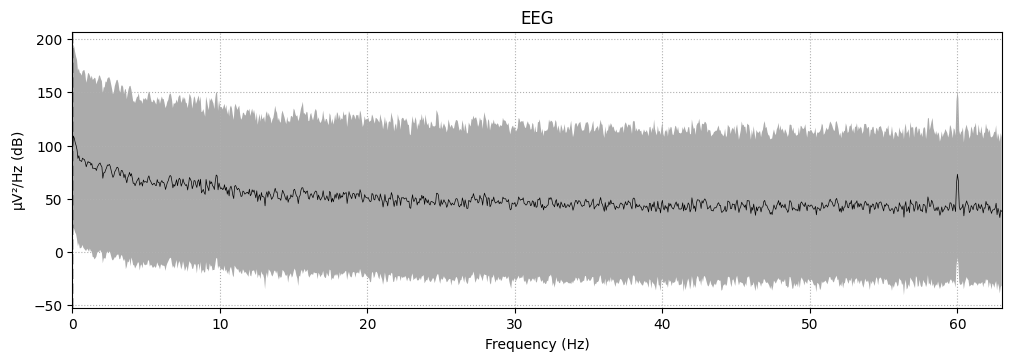

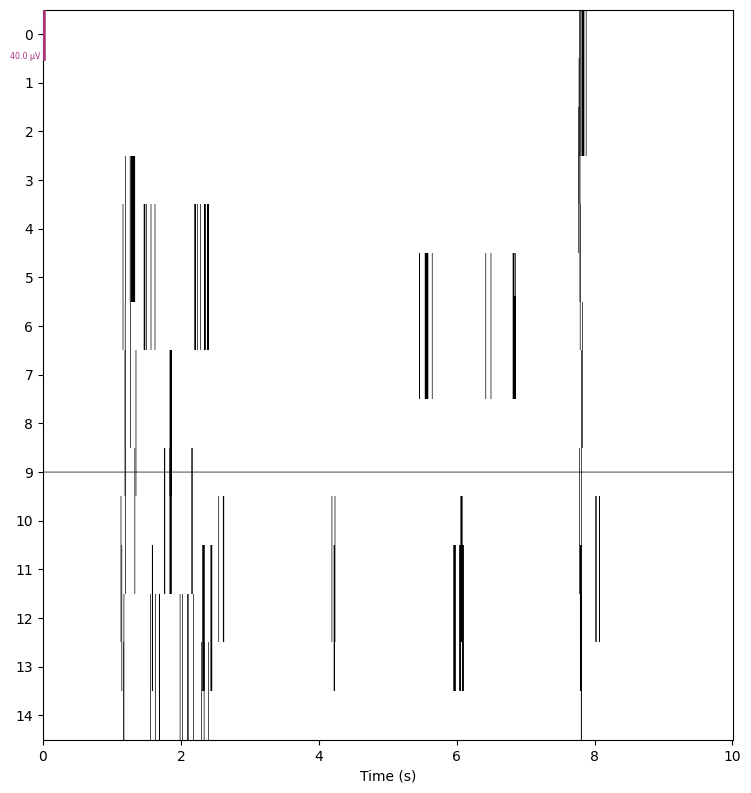

Effective window size : 2.000 (s)
freqs [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5
 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5
 63. ] psds [[1.26139891e-02 7.94449829e-02 1.72977408e-02 ... 2.10341362e-06
  2.67694167e-06 2.85044942e-06]
 [1.16279472e-02 7.18341701e-02 1.30782534e-02 ... 2.80135284e-06
  3.30660518e-06 2.40875088e-06]
 [1.30638618e-02 9.49142966e-02 1.54242150e-02 ... 4.59703793e-06
  5.91465515e-06 3.21814748e-06]
 ...
 [1.862

In [20]:
import time
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGSSL()
model.to(device=device)
model.train()
for e in range(1):
    start_time = time.time()
    for t, samples in enumerate(dataloader):
        eeg_utils.plot_raw_eeg(samples[0][:15,:].numpy(), 128)
        print(samples[0].mean(dim=1))
        print(samples[0].std(dim=1))
        break
        # shuffling_indices = list(range(samples.shape[0]))
        # np.random.shuffle(shuffling_indices)
        # # subj = np.array(subj)[shuffling_indices]
        # shuffling_indices = torch.tensor(shuffling_indices)
        # samples = torch.index_select(samples, 0, shuffling_indices)

        # samples = samples.to(device=device, dtype=torch.float32)
        # print(model(samples).shape)
        # print('Iteration %d took %s second(s)' % (t, time.time() - start_time))
        # start_time = time.time()

In [1]:
task = MaskedContrastiveLearningTask(
    dataset=dataset,
    is_cv=False,
    is_iterable=True,
    train_params={
        'num_epochs': 100,
        'batch_size': 128,
        'print_every': 10,
        'learning_rate': 0.001,
    }
)
model = Wav2VecBrainModel()
task.train(model=model)

NameError: name 'MaskedContrastiveLearningTask' is not defined

In [26]:
dataset = HBNRestBIDSDataset(
        data_dir = "/mnt/nemar/openneuro/ds004186",
        x_params = {
            'sfreq': 128,
            'window': 20,
        },
    )
model = VGGSSL()
trainer = Trainer(
    dataset=dataset,
    model=model,
    train_params={
        'num_epochs': 10,
        'batch_size': 12,
        'print_every': 1,
        'learning_rate': 0.00001,
        'num_workers': 0,
    },
    task_params={
        'task': 'RelativePositioning',
        'sfreq': 128,
        'win': 2,
        'tau_pos': 10,
        'tau_neg': 10,
        'n_samples': 1,
    },
    verbose=False,
)
trainer.train()

Training on  cuda
Epoch 0, Iteration 0, loss = 0.6765
Epoch 0, Iteration 1, loss = 0.6762
Epoch 0, Iteration 2, loss = nan
Epoch 0, Iteration 3, loss = nan
Epoch 0, Iteration 4, loss = nan
Epoch 0, Iteration 5, loss = nan


KeyboardInterrupt: 

In [3]:
dataset = HBNSignalstoreDataset(
        task_params={
            "window": 2,
            "task": "EC",
        },
        data_directory='/local/directory/spectral'
    )

dataset_spectral = eeg_dash.transform(dataset, feature='spectral', window=2, directory='/local/directory/dataset/spectral')
dataset_entropy = eeg_dash.transform(dataset_spectral, feature='entropy', directory='/local/directory/dataset/entropy')

Found 17 records


In [ ]:
dataset = HBNSignalstoreDataset(
        task_params={
            "window": 2,
            "sfreq": 128,
            "task": "EC",
            "feature": "spectral"
        },
        data_directory='/local/directory/spectral'
    )

In [13]:
import time
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Wav2VecBrainModel()
model.to(device=device)
model.train()
for e in range(1):
    start_time = time.time()
    for t, (samples, subj) in enumerate(dataloader):
        shuffling_indices = list(range(samples.shape[0]))
        np.random.shuffle(shuffling_indices)
        subj = np.array(subj)[shuffling_indices]
        shuffling_indices = torch.tensor(shuffling_indices)
        samples = torch.index_select(samples, 0, shuffling_indices)

        samples = samples.to(device=device, dtype=torch.float32)
        # print(model(samples).shape, subj)
        print('Iteration %d took %s second(s)' % (t, time.time() - start_time))
        start_time = time.time()

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Found 1 records
Iteration 0 took 4.392029523849487 second(s)
Iteration 1 took 3.235060691833496 second(s)
Iteration 2 took 2.800579071044922 second(s)
Iteration 3 took 2.7360587120056152 second(s)
Iteration 4 took 2.677096366882324 second(s)
Iteration 5 took 3.2928202152252197 second(s)
Iteration 6 took 3.996832847595215 second(s)
Iteration 7 took 2.5395424365997314 second(s)
Iteration 8 took 2.7171616554260254 second(s)


KeyboardInterrupt: 